# Sentiment Analysis COVID19 in Indonesia

## Preparation

### Import Libraries

In [2]:
# Import Library Standard
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Import Library Sklearn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.pipeline import make_pipeline

# Import Library untuk Stemming
#pip install Sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

In [3]:
#pip install wordcloud
from wordcloud import WordCloud

In [4]:
# Read Dataset
data = pd.read_excel('dataset_psbb.xlsx')
data.head()

No                                           Mentions Sentiment
0   1  RT @Moohd_Ilham: Jika dibandingkan dengan jala...  Positive
1   2                                 Laaah gua tim PSBB  Positive
2   3  RT Berdasarkan Peraturan Wali Kota Surabaya no...  Positive
3   4  @PRFMnews Ieu teh psbb atau lockdown sih ? Cum...  Negative
4   5  RT "Buat Mengobati Kangen Selama PSBB, Silahka...  Positive

### Data Exploration

In [5]:
df = data[['Mentions', 'Sentiment']].copy()
df.rename(columns={'Mentions':'komentar', 'Sentiment':'label'}, inplace=True)
print('Ukuran Dataset: ', df.shape)
df.head()

Ukuran Dataset:  (125498, 2)


komentar     label
0  RT @Moohd_Ilham: Jika dibandingkan dengan jala...  Positive
1                                 Laaah gua tim PSBB  Positive
2  RT Berdasarkan Peraturan Wali Kota Surabaya no...  Positive
3  @PRFMnews Ieu teh psbb atau lockdown sih ? Cum...  Negative
4  RT "Buat Mengobati Kangen Selama PSBB, Silahka...  Positive

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


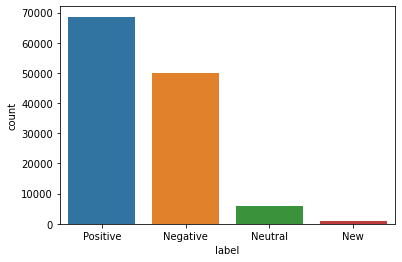

In [6]:
import seaborn as sns
sns.countplot(df['label']);

In [7]:
print("CONTOH KOMENTAR HASIL SCRAPPING\n")
for i in range(1,5):
      print(f"KOMENTAR{i}:\n {df['komentar'][i]}")

CONTOH KOMENTAR HASIL SCRAPPING

KOMENTAR1:
 Laaah gua tim PSBB
KOMENTAR2:
 RT Berdasarkan Peraturan Wali Kota Surabaya nomor 16 tahun 2020, ada beberapa poin yang dibatasi dan diperbolehkan dalam PSBB di Kota Surabaya. Berikut #InfografiSSnya. https://t.co/dNCTLX4UYt [RE e100ss]
KOMENTAR3:
 @PRFMnews Ieu teh psbb atau lockdown sih ? Cuma nanya ~
KOMENTAR4:
 RT "Buat Mengobati Kangen Selama PSBB, Silahkan Menikmati Ekspresi Ngangenin WTS Di Video"#Bukapuasa #kyutv #JanganCobaMudik #DisiplinKunciHadapiCorona #kangennaikkereta #ramadankareem #RamadanKareem2020 @one_vase @Mssgandra @marioleewook @CanduPijat @DMa


banyak komentar yang masih mengandung link http, spasi dan @akun sehingga perlu dibersihkan terlebih dahulu

## Preprocessing

### cleanning

In [8]:
def clean_tweet(tweet):
    """ cleaning tweet 
    source code: https://www.machinelearningplus.com/python/python-regex-tutorial-examples/
    """
    tweet = re.sub('http\S+\s*', '', tweet)  # remove URLs
    tweet = re.sub('pic\.\S+', '', tweet)  # remove picture twitter URLs
    tweet = re.sub('RT|cc', '', tweet)  # remove RT and cc
    tweet = re.sub('#\S+', '', tweet)  # remove hashtags
    tweet = re.sub('@\S+', '', tweet)  # remove mentions
    tweet = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), '', tweet)  # remove punctuations
    tweet = re.sub('\s+', ' ', tweet)  # remove extra whitespace
    return tweet

In [12]:
df['komentar'] = df['komentar'].apply(lambda x:clean_tweet(x))

In [13]:
negatif_komen = df[df['label'] == 'Negative']['komentar'].values
neutral_komen = df[df['label'] == 'Neutral']['komentar'].values
positif_komen = df[df['label'] == 'Positive']['komentar'].values
new_komen = df[df['label'] == 'Positive']['komentar'].values

### Spell Correction

#### Stemming

In [14]:
# Membuat stemmer
stemmerFactory = StemmerFactory()
stemmer = stemmerFactory.create_stemmer()

# Daftar Stopword
stopWordRemoverFactory = StopWordRemoverFactory()
stopwords = stopWordRemoverFactory.get_stop_words()

In [15]:
def word_cloud(x, stop=stopwords):
    words = WordCloud(width=3000, height=2000, stopwords=stop).generate(str(x))
    plt.figure(figsize=(40,30), edgecolor='k', facecolor='k')
    plt.imshow(words, interpolation='bilinear')
    plt.axis(False)
    plt.tight_layout(pad=0)
    plt.show()

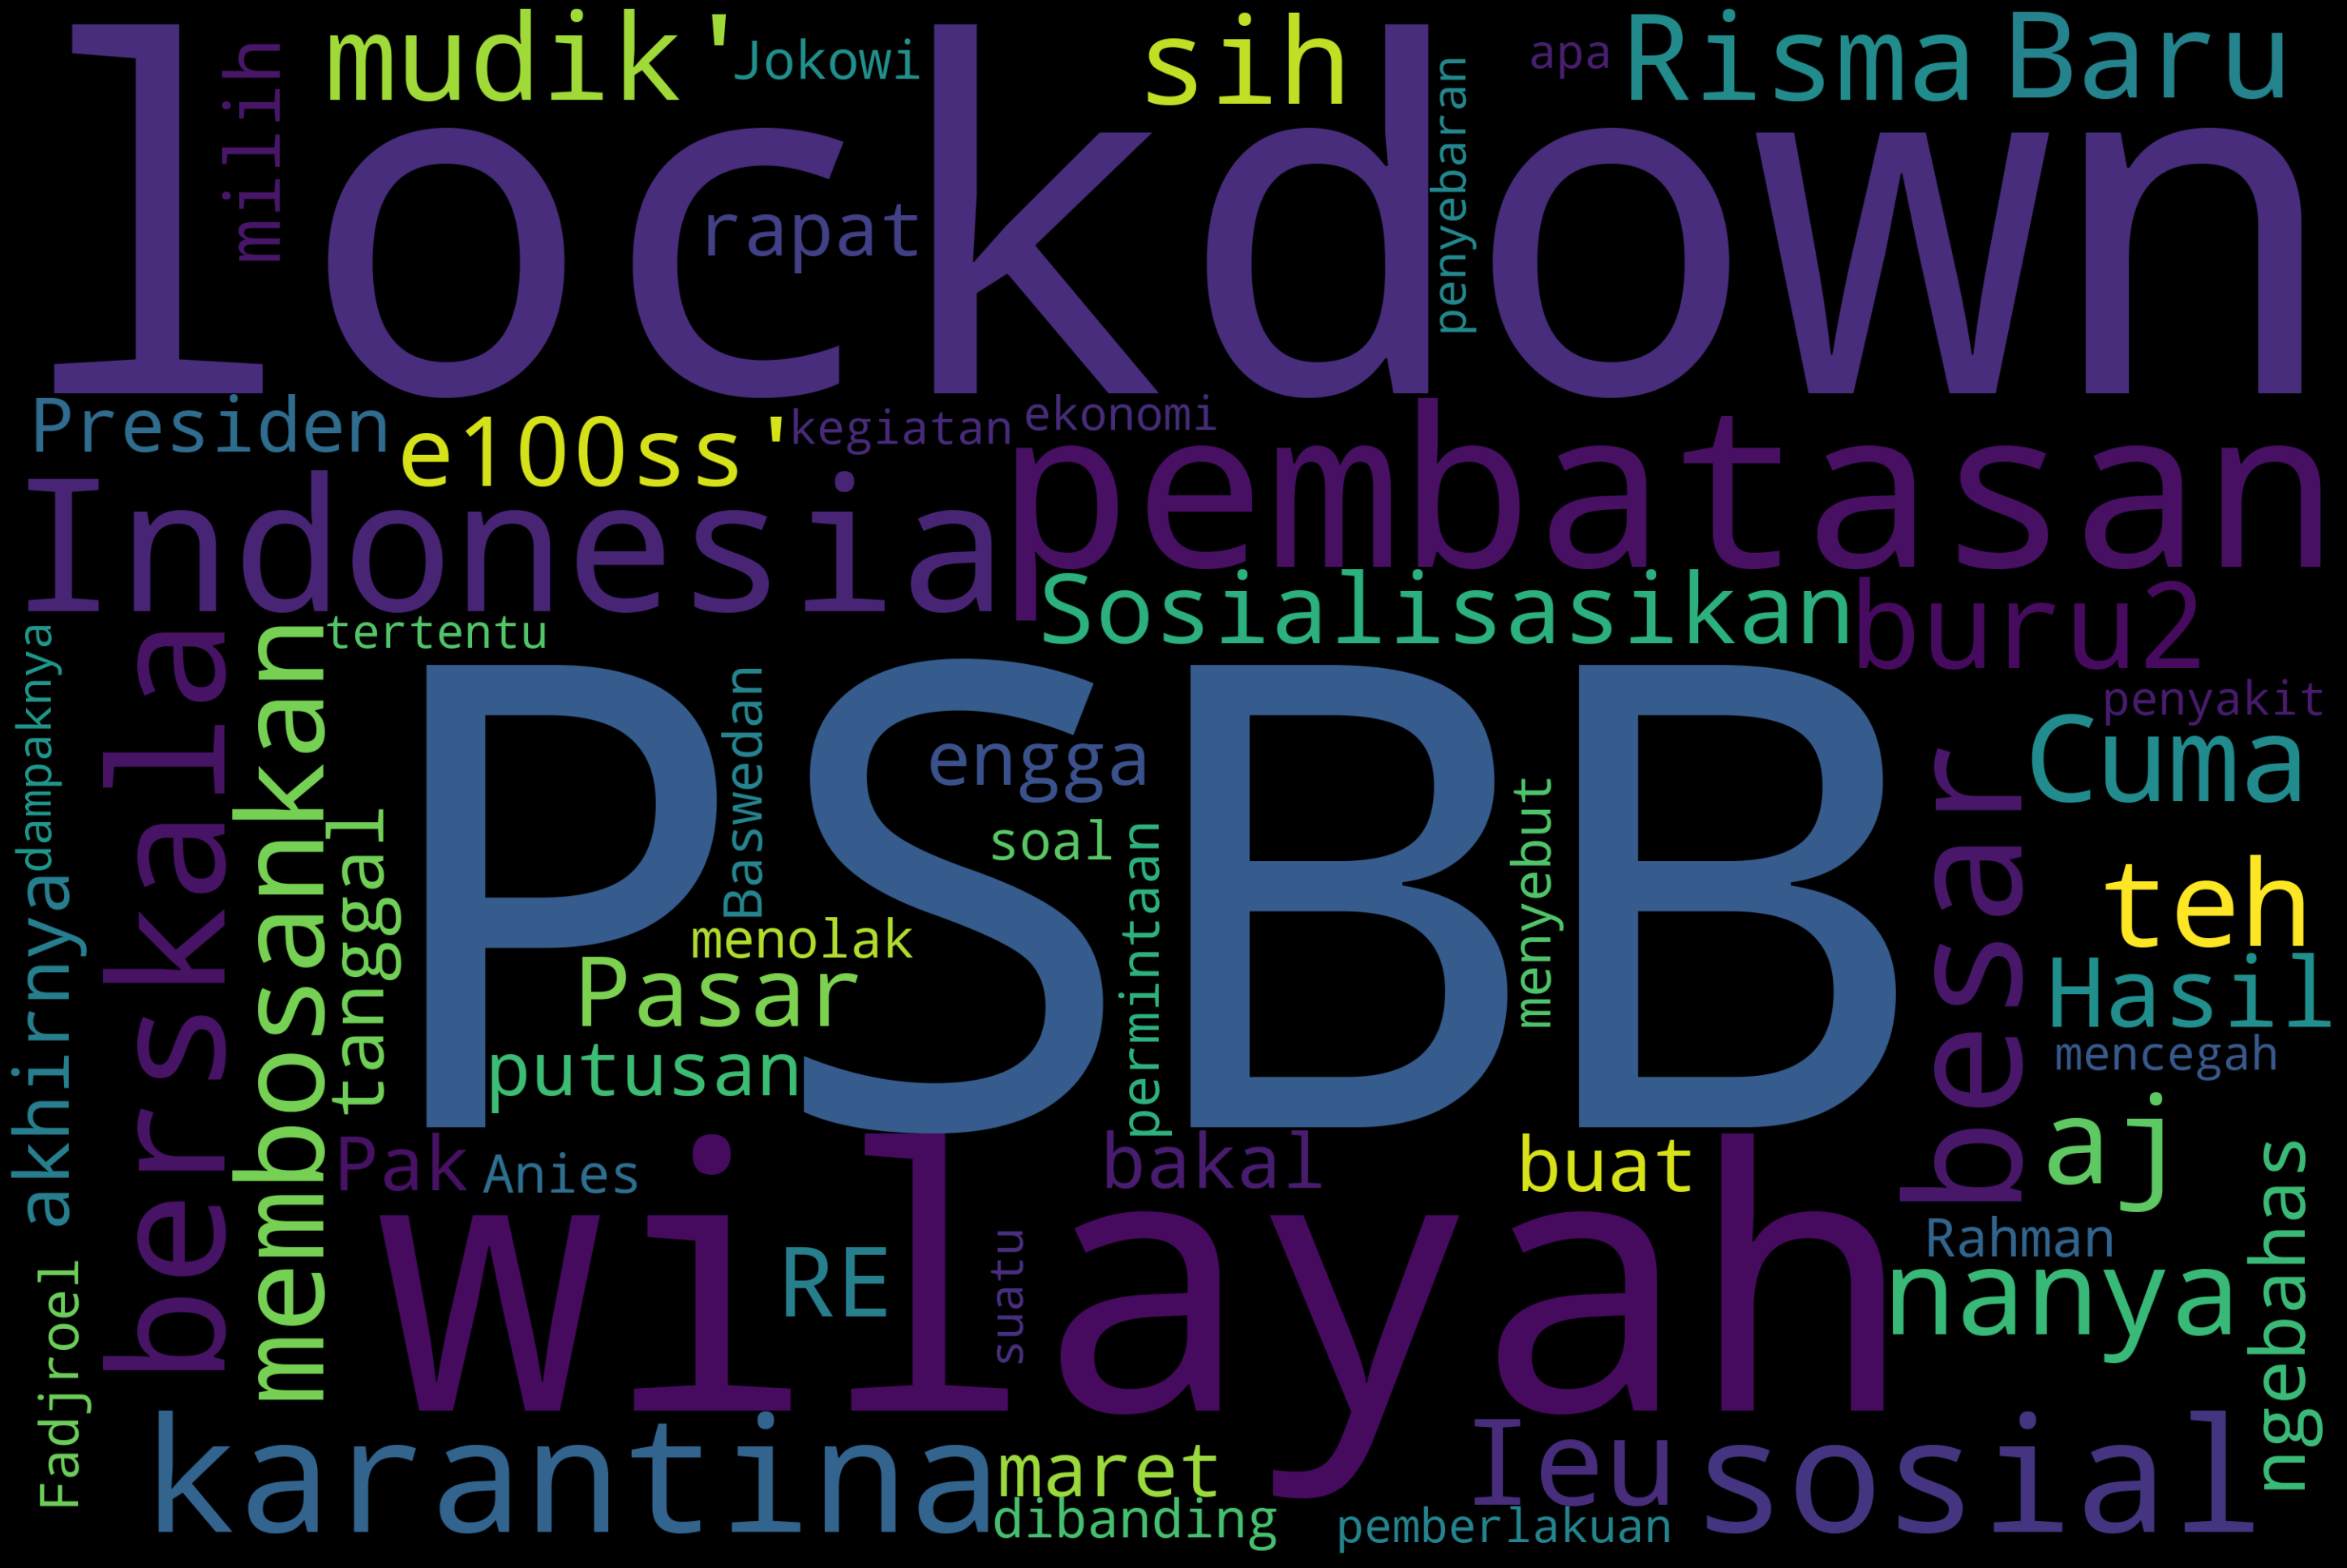

In [16]:
word_cloud(negatif_komen)

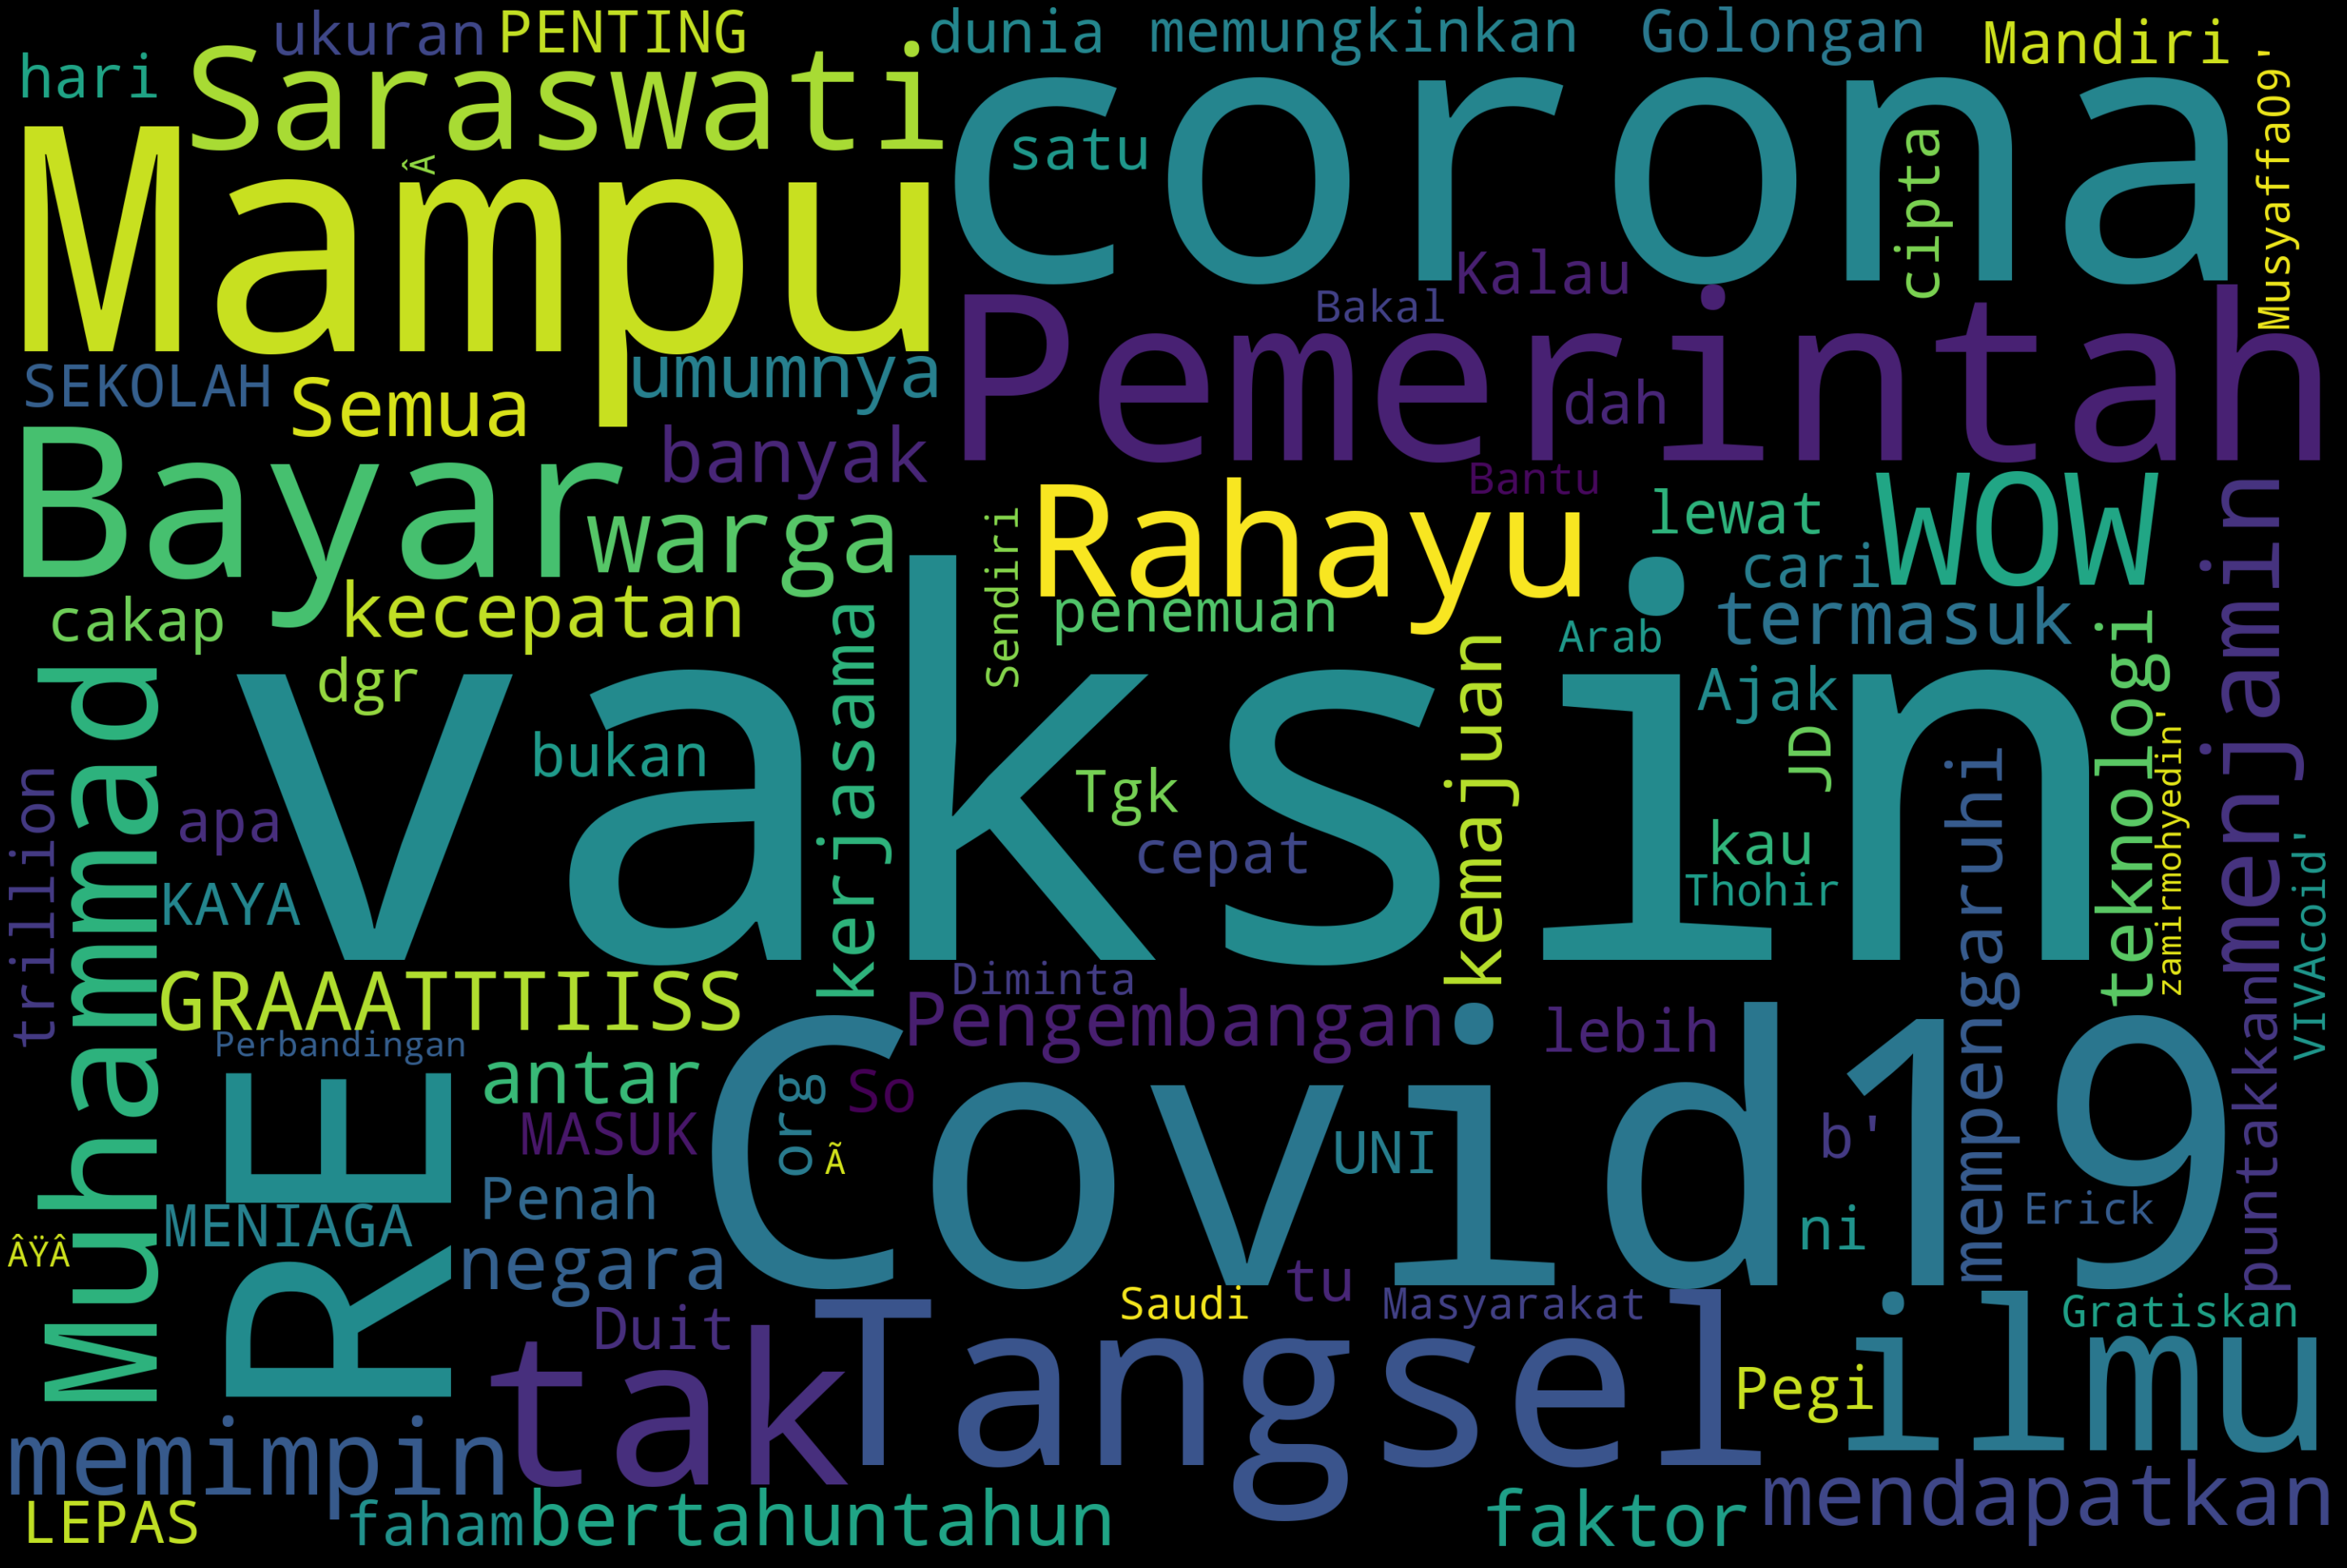

In [14]:
word_cloud(neutral_komen)

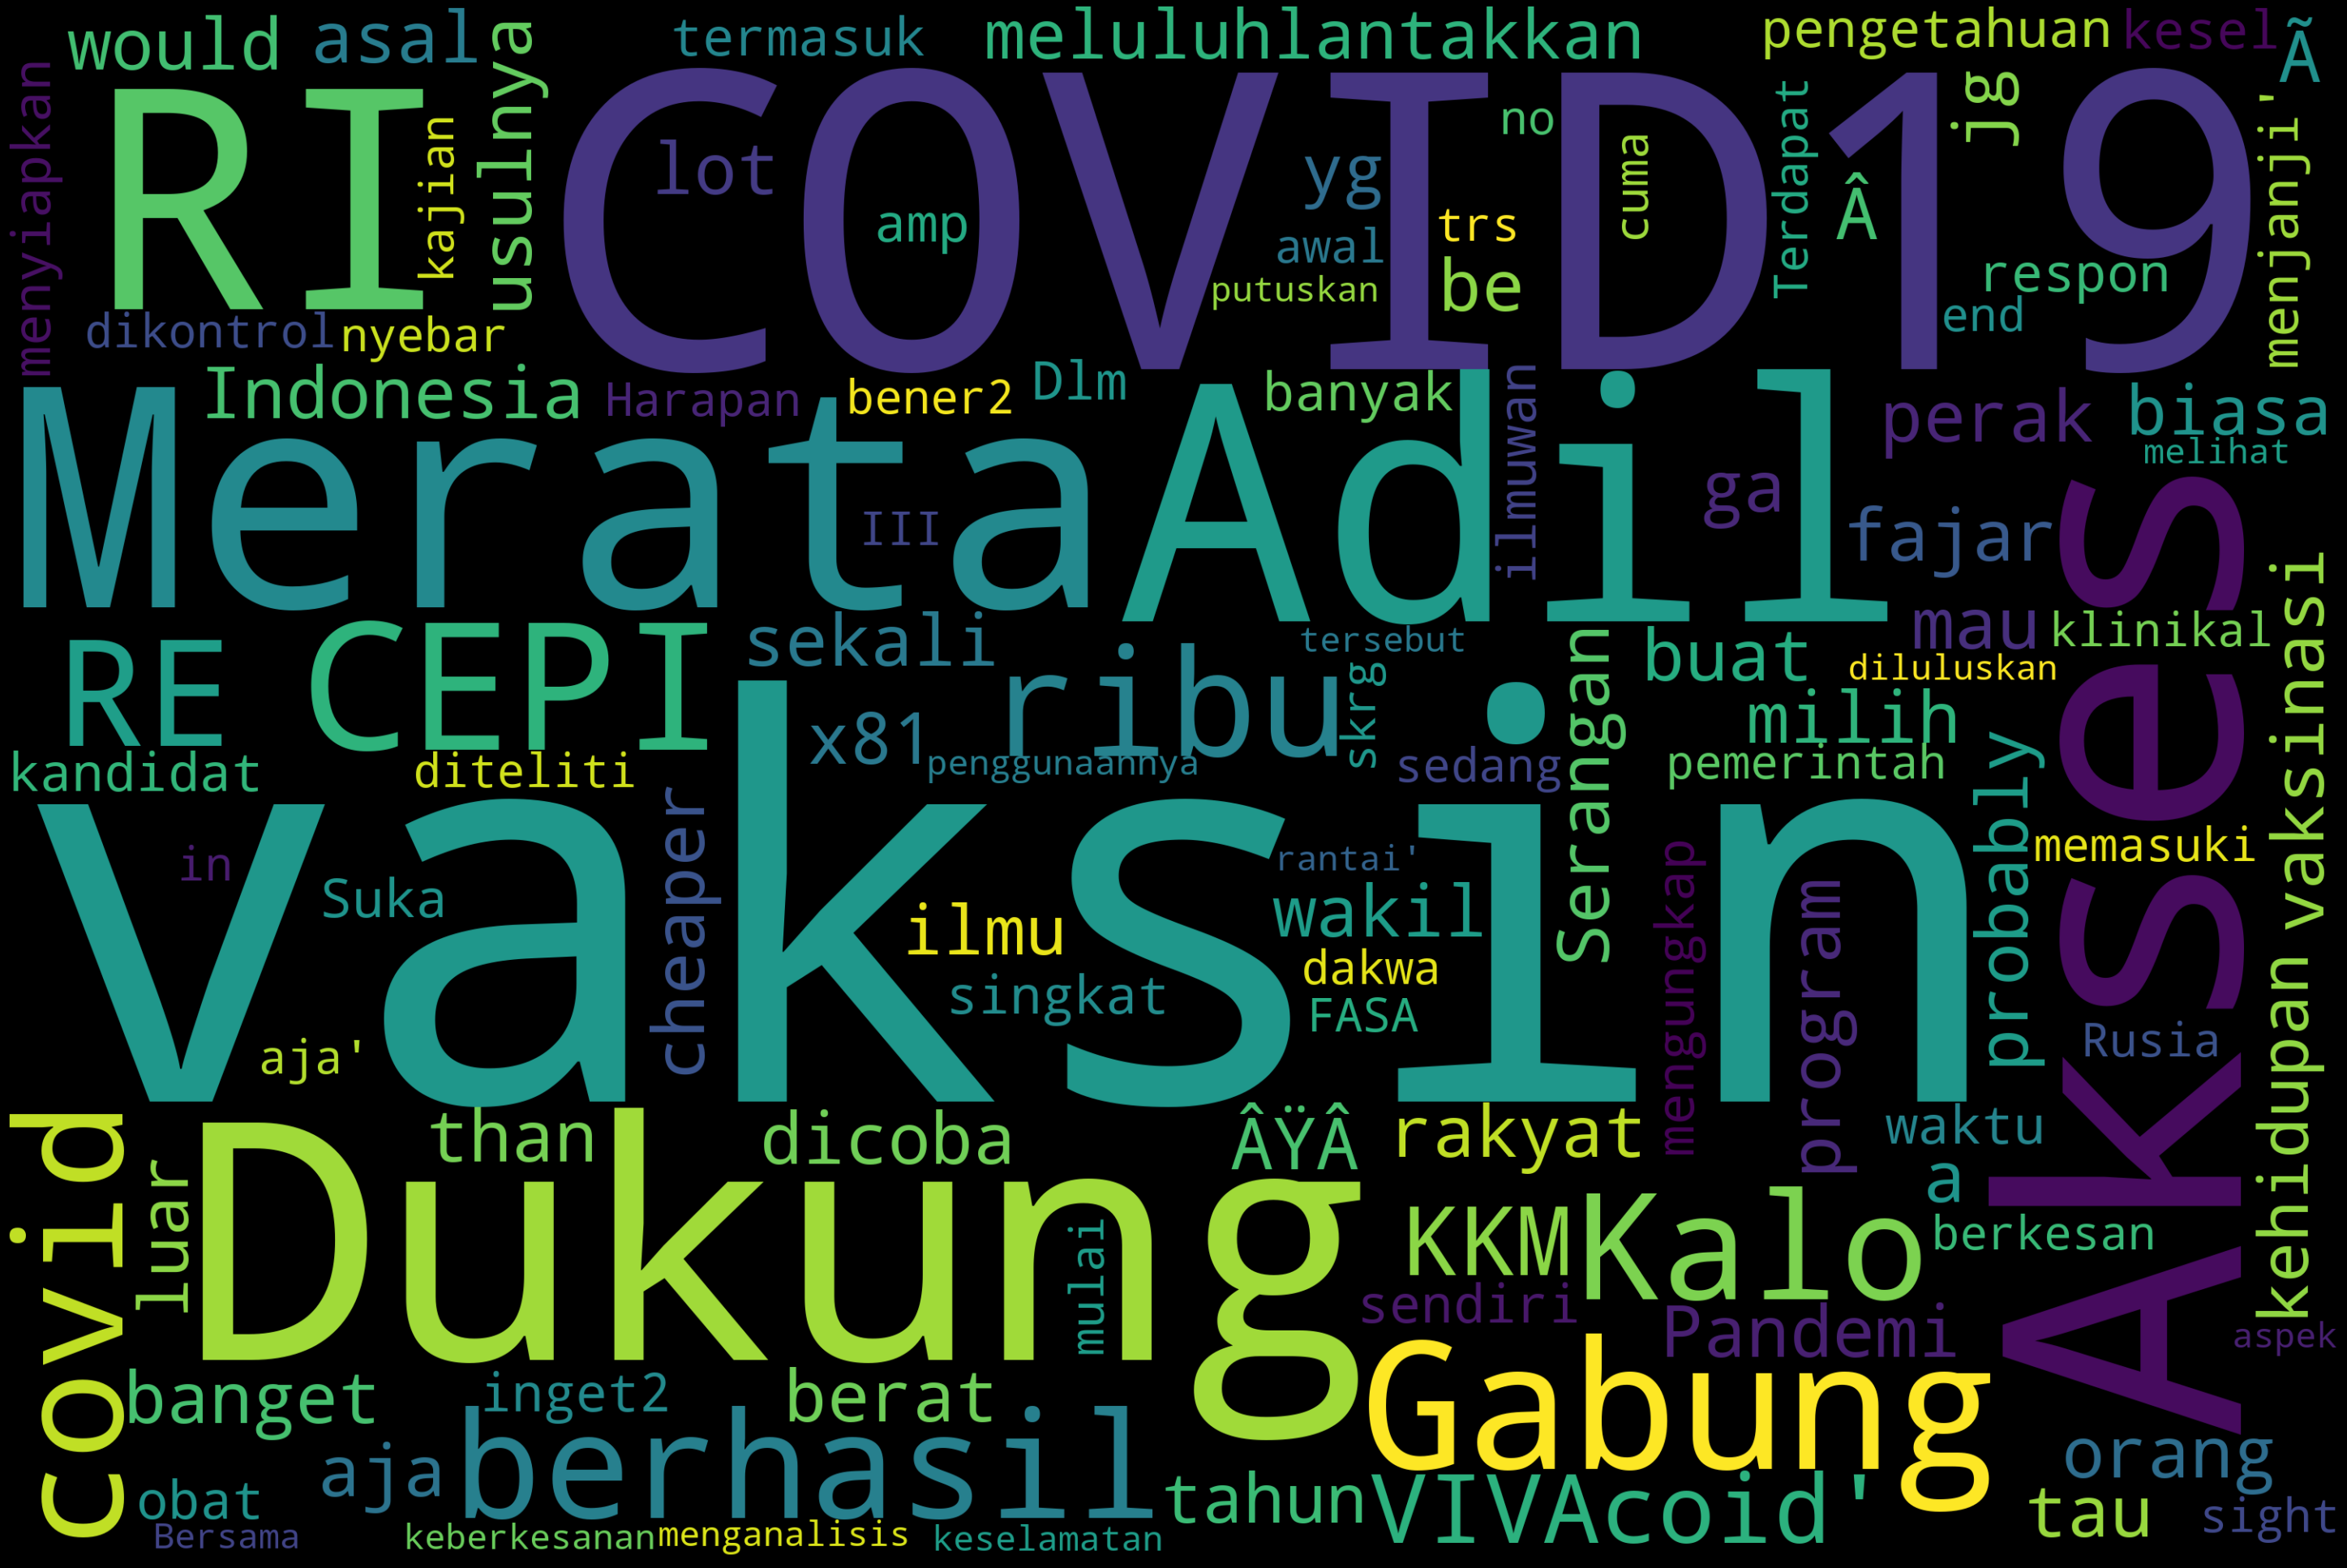

In [15]:
word_cloud(positif_komen)

In [17]:
df['komentar'] = df['komentar'].apply(lambda x: stemmer.stem(x))

In [18]:
df_clean = pd.DataFrame()
df_clean['Komentar_scraping'] = data['Mentions']
df_clean['Komentar_clean'] = df['komentar']
df_clean['label'] = df['label']
df_clean.head(5)

Komentar_scraping  \
0  RT @Moohd_Ilham: Jika dibandingkan dengan jala...   
1                                 Laaah gua tim PSBB   
2  RT Berdasarkan Peraturan Wali Kota Surabaya no...   
3  @PRFMnews Ieu teh psbb atau lockdown sih ? Cum...   
4  RT "Buat Mengobati Kangen Selama PSBB, Silahka...   

                                      Komentar_clean     label  
0  jika banding dengan jalan telah psbb chatku ny...  Positive  
1                                 laaah gua tim psbb  Positive  
2  dasar atur wali kota surabaya nomor 16 tahun 2...  Positive  
3          ieu teh psbb atau lockdown sih cuma nanya  Negative  
4  buat obat kangen lama psbb silah nikmat ekspre...  Positive

In [19]:
df_clean.to_excel("cleaning_data_PSBB.xlsx")

In [21]:
# pemisahan feature dan label
X = df['komentar']
y = df['label']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, stratify=y)
print(f"training size {X_train.size}")
print(f"validasi size {X_val.size}")

training size 18
validasi size 3


In [22]:
# encoding data label menjadi numberik karena data awal berupa teks positif, neutral dan negatif
encoder = LabelEncoder()
y_train_code = encoder.fit_transform(y_train)
y_val_code = encoder.transform(y_val)
print(y_train_code[:10])
encoder.classes_ #negatif=0, neutral=1, positif=2

[1 1 2 2 1 0 1 0 2 0]


array(['Negative', 'Neutral', 'Positive'], dtype=object)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Data Training')

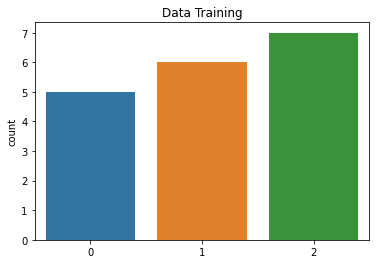

In [23]:
sns.countplot(y_train_code)
plt.title('Data Training')

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Data Validasi')

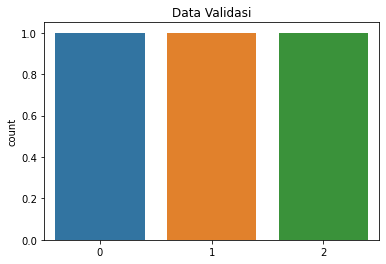

In [24]:
sns.countplot(y_val_code)
plt.title('Data Validasi')

## Tokenisasi and Vocabulary building


In [25]:
vectorizer = TfidfVectorizer(min_df=2, ngram_range=(1,2), stop_words=stopwords) #ekstraksi fitur
#min_df = minimal kata minimal muncul 3 kali di dokumen
#stopwords = menghilangkan kata yang sering muncul di bahasa indonesia

#fit dan data tranformasi
bag_of_words = vectorizer.fit_transform(X_train)
X_val_vect = vectorizer.transform(X_val)

feature_names = vectorizer.get_feature_names()
print(feature_names[200:215])
print(feature_names[1000:1015])

#model fit
mnNB = MultinomialNB()
mnNB.fit(bag_of_words, y_train_code)
print("\naccuracy training random 1 fold", mnNB.score(bag_of_words, y_train_code))
cv = cross_val_score(mnNB, bag_of_words, y_train_code, cv=2,scoring='accuracy') #data validasi
print("accuracy training random 10 fold", cv)
print("mean accuracy", np.mean(cv))

[]
[]

accuracy training random 1 fold 0.8888888888888888
accuracy training random 10 fold [0.66666667 0.44444444]
mean accuracy 0.5555555555555556


In [26]:
#model fit
svc = SVC()
svc.fit(bag_of_words, y_train_code)


print("\naccuracy training random 1 fold", svc.score(bag_of_words, y_train_code))
cv = cross_val_score(svc, bag_of_words, y_train_code, cv=2,scoring='accuracy') #data validasi
print("accuracy training random 10 fold", cv)
print("mean accuracy", np.mean(cv))


accuracy training random 1 fold 0.9444444444444444
accuracy training random 10 fold [0.44444444 0.44444444]
mean accuracy 0.4444444444444444


## Modelling

### Model Selection

In [27]:
#model selection untuk memilih model machine learning mana yang memberikan hasil yg baik
models = {'SVC' : SVC(), 'LogisticRegression': LogisticRegression(), 'MultinomialNB': MultinomialNB(),
         'RidgeClassifier' : RidgeClassifier(), 'KNeighborsClassifier':KNeighborsClassifier()}

score={}
for n, model in models.items():
    score[n] = np.mean(cross_val_score(model, bag_of_words, y_train_code, cv=2,scoring='accuracy'))

sorted(score.items(), key=lambda x:x[1], reverse=True)

[('MultinomialNB', 0.5555555555555556),
 ('LogisticRegression', 0.5),
 ('RidgeClassifier', 0.5),
 ('SVC', 0.4444444444444444),
 ('KNeighborsClassifier', 0.3333333333333333)]

### Parameter Tuning Using Pipeline

In [28]:
#model parameter tuning
#random search untuk mencari parameter kasar sebelum dilakukan gridsearch
pipe_random = make_pipeline(TfidfVectorizer(stop_words=stopwords), SVC())
param = {'svc__C': [0.01, 0.1, 1],
        'tfidfvectorizer__ngram_range':[(1, 1), (1,2), (1,3), (1,4)],
        'tfidfvectorizer__min_df':[1, 2, 3, 4, 5]}

rand_search = RandomizedSearchCV(pipe_random, param_distributions=param, cv=2)
rand_search.fit(X_train, y_train_code)
print("Best cross-validation score: ", rand_search.best_score_)
print("Best parameters: ", rand_search.best_estimator_)

Best cross-validation score:  0.5
Best parameters:  Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(ngram_range=(1, 4),
                                 stop_words=['yang', 'untuk', 'pada', 'ke',
                                             'para', 'namun', 'menurut',
                                             'antara', 'dia', 'dua', 'ia',
                                             'seperti', 'jika', 'jika',
                                             'sehingga', 'kembali', 'dan',
                                             'tidak', 'ini', 'karena', 'kepada',
                                             'oleh', 'saat', 'harus',
                                             'sementara', 'setelah', 'belum',
                                             'kami', 'sekitar', 'bagi', ...])),
                ('svc', SVC(C=0.01))])


In [29]:
#grid search ini saya lakukan untuk mempersempit parameter tuning dari random search
pipe_grid = make_pipeline(TfidfVectorizer(stop_words=stopwords), SVC())
param = {'svc__C': [0.01, 0.1, 1],
        'tfidfvectorizer__ngram_range':[(1,2), (1,3), (1,4)],
        'tfidfvectorizer__min_df':[2, 3]}

grid = GridSearchCV(pipe_grid, param_grid=param, cv=2)
grid.fit(X_train, y_train_code)
print("Best cross-validation score: ", grid.best_score_)
print("Best parameters: ", grid.best_estimator_)

Best cross-validation score:  0.4444444444444444
Best parameters:  Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(min_df=2, ngram_range=(1, 3),
                                 stop_words=['yang', 'untuk', 'pada', 'ke',
                                             'para', 'namun', 'menurut',
                                             'antara', 'dia', 'dua', 'ia',
                                             'seperti', 'jika', 'jika',
                                             'sehingga', 'kembali', 'dan',
                                             'tidak', 'ini', 'karena', 'kepada',
                                             'oleh', 'saat', 'harus',
                                             'sementara', 'setelah', 'belum',
                                             'kami', 'sekitar', 'bagi', ...])),
                ('svc', SVC(C=1))])


### Model Evaluation

In [30]:
pipe_v1 = make_pipeline(TfidfVectorizer(min_df=2, ngram_range=(1,2), stop_words=stopwords),
                     SVC())
pipe_v1.fit(X_train, y_train_code)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(min_df=2, ngram_range=(1, 2),
                                 stop_words=['yang', 'untuk', 'pada', 'ke',
                                             'para', 'namun', 'menurut',
                                             'antara', 'dia', 'dua', 'ia',
                                             'seperti', 'jika', 'jika',
                                             'sehingga', 'kembali', 'dan',
                                             'tidak', 'ini', 'karena', 'kepada',
                                             'oleh', 'saat', 'harus',
                                             'sementara', 'setelah', 'belum',
                                             'kami', 'sekitar', 'bagi', ...])),
                ('svc', SVC())])

training report
              precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.86      1.00      0.92         6
           2       1.00      1.00      1.00         7

    accuracy                           0.94        18
   macro avg       0.95      0.93      0.94        18
weighted avg       0.95      0.94      0.94        18



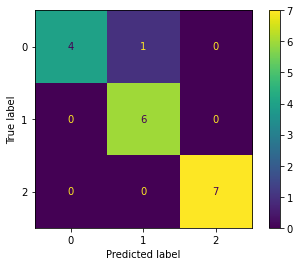

In [31]:
print('training report')
plot_confusion_matrix(pipe_v1, X_train, y_train_code)
print(classification_report(y_train_code, pipe_v1.predict(X_train)))

testing report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       1.00      1.00      1.00         1
           2       0.00      0.00      0.00         1

    accuracy                           0.33         3
   macro avg       0.33      0.33      0.33         3
weighted avg       0.33      0.33      0.33         3



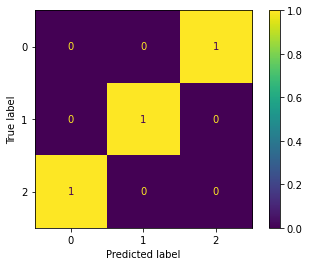

In [32]:
print('testing report')
plot_confusion_matrix(pipe_v1, X_val, y_val_code)
print(classification_report(y_val_code, pipe_v1.predict(X_val)))